In [1]:
using LinearAlgebra
using Random
using NPZ
using Dates

# projection function onto the design space
function proj(x)
    a = x[1:p*k]
    b = x[(1:k) .+ (p*k)]
    
    a = reshape(a,p,k)
    a = max.( a, design[:,1] )
    a = min.( a, design[:,2] )
    a = reshape(a,p*k)
    
    u = sort(b, rev=true)
    j = k
    while true
        if u[j] + 1/j*(1-cumsum(u)[j]) > 0
            break
        end
        j -= 1
    end
    lambda = 1/j*(1-cumsum(u)[j])
    b = max.(b .+ lambda,0)
    b = 0.5*b
    
    return [a;b]
end

function proj2(x)
    x = max.(x,design2[:,1])
    x = min.(x,design2[:,2])
    return x
end

function pso2(xx,lp2)
    #initialize
    #srand(1992)
    path2 = zeros(niter2)
    tau2 = 0.9:(-0.5/niter2):0.4
    v2 = zeros(nptc2, p2)
    ptc2 = rand(nptc2, p2)
    for j2 in 1:p2
            ptc2[:,j2] = (design2[j2,2] - design2[j2,1]) * ptc2[:,j2] .+ design2[j2,1]
    end
    pbesth2 = zeros(nptc2)
    pbest2 = ptc2
    for j2 in 1:nptc2
        pbesth2[j2] = obj(xx,pbest2[j2,:])
    end
    gbesth2 = findmax(pbesth2)[1]
    gbest2 = pbest2[findmax(pbesth2)[2],:]

    #iterate
    for i2 in 1:niter2 # iteration number
            g12 = rand(p2)
            g22 = rand(p2)
        for j2 in 1:nptc2 # particle number
            v2[j2,:] = tau2[i2] .*v2[j2,:] + lp2 .* g12 .*(pbest2[j2,:]-ptc2[j2,:]) + lp2 .* g22 .*(gbest2-ptc2[j2,:])
            ptc2[j2,:] = ptc2[j2,:] + v2[j2,:]
            ptc2[j2,:] = proj2(ptc2[j2,:])
            fit2 = obj(xx,ptc2[j2,:])
            if fit2 > gbesth2
                gbesth2 = pbesth2[j2] = fit2
                gbest2 = pbest2[j2,:] = ptc2[j2,:]
            elseif fit2 > pbesth2[j2]
                pbesth2[j2] = fit2
                pbest2[j2,:] = ptc2[j2,:]
            end
        end
        path2[i2] = gbesth2
    end
    return [gbesth2; gbest2; path2]
end

function pso(lp,lp2)
    #initialize
    #srand(1992)
    path = zeros(niter)
    tau = 0.9:(-0.5/niter):0.4
    v = zeros(nptc, p*k+k)
    x = rand(nptc,p*k)
    for j in 1:p
        x[:,p*(1:k).+(j-p)] = (design[j,2]-design[j,1]) * x[:,p*(1:k).+(j-p)] .+ design[j,1]
    end    
    w = randexp(nptc,k)
    for j in 1:nptc
            w[j,:] = 0.5*w[j,:] ./ sum(w[j,:])
    end
    ptc = hcat(x,w)
    pbest = ptc
    pbesth = zeros(nptc)
    for j in 1:nptc
        pbesth[j] = pso2(pbest[j,:],lp2)[1]
    end
    gbesth = findmin(pbesth)[1]
    gbest = pbest[findmin(pbesth)[2],:]
    
    tbest = zeros(p2)
    
    #iterate
    for i in 1:niter # iteration number
            g1 = rand(p*k+k)
            g2 = rand(p*k+k)
        for j in 1:nptc # particle number
            v[j,:] = tau[i] .*v[j,:] + lp .* g1 .*(pbest[j,:]-ptc[j,:]) + lp .* g2 .*(gbest-ptc[j,:])
            ptc[j,:] = ptc[j,:] + v[j,:]
            ptc[j,:] = proj(ptc[j,:])
            fit = pso2(ptc[j,:],lp2)
            if fit[1] < gbesth
                gbest = pbest[j,:] = ptc[j,:]
                gbesth = pbesth[j] = fit[1]
                tbest = fit[(1:p2) .+ 1]
            elseif fit[1] < pbesth[j]
                pbest[j,:] = ptc[j,:]
                pbesth[j] = fit[1]
            end
        end
        path[i] = gbesth
        print(".")
    end
    
    return [gbesth; gbest; tbest; path]
end

pso (generic function with 1 method)

In [6]:
function showsummary(x)
    support = reshape(x[(1:p*k).+1],p,k)
    weight = x[(1:k) .+ (p*k+1)]
    theta = x[(1:p2) .+ (p*k+k+1)]
    optimum = x[1]
    return [support, weight, theta, optimum]
end

function showplot(x)
    path = x[(1:niter) .+ (length(x)-niter)]
    return plot(1:niter, path, color="red", linewidth=2.0, linestyle="solid")
end

function showsummary2(x)
    theta = x[(1:p2).+1]
    optimum = x[1]
    return [theta, optimum]
end

function showplot2(x)
    path = x[(1:niter2) .+ (length(x)-niter2)]
    return plot(1:niter2, path, color="red", linewidth=2.0, linestyle="solid")
end

showplot2 (generic function with 1 method)

In [2]:
function obj(eta, theta)
    mat = zeros(2,2)
    b = theta[2]
    a = theta[1]
    for i in 1:k
        m0 = zeros(2)
        s = eta[i]
        w = eta[i+k]
        m0[1] = b
        m0[2] = -s+a
        p = 1/(1+exp(-b*(s-a))) 
        mat = mat + w * p*(1-p) * m0*m0' 
    end
    for i in 1:k
        m0 = zeros(2)
        s = (design2[1,2]+design2[1,1]) - eta[i]
        w = eta[i+k]
        m0[1] = b
        m0[2] = -s+a
        p = 1/(1+exp(-b*(s-a))) 
        mat = mat + w * p*(1-p) * m0*m0' 
    end
    if det(mat) < 10.0^-6
        return Inf
    else
        return -log(det(mat))
    end
end

obj (generic function with 1 method)

In [3]:
# outer loop
k = 2
nptc = 32
niter = 100
design = [-1 4]
p = size(design)[1]


# inner loop
nptc2 = 64
niter2 = 50
design2 =  [0 2.5 ; 1 3]
p2 = size(design2)[1]

2

In [4]:
result = npzread("ex32a_sym.npy")

107-element Array{Float64,1}:
  4.067119082383512  
  1.4527205223921358 
 -0.30724051193734914
  0.2564201973543283 
  0.24357980264567172
  1.2499995175859577 
  3.0                
  4.320131663199522  
  4.279044730052916  
  4.253619356513653  
  4.242679639813121  
  4.242679639813121  
  4.242679639813121  
  ⋮                  
  4.067119082383512  
  4.067119082383512  
  4.067119082383512  
  4.067119082383512  
  4.067119082383512  
  4.067119082383512  
  4.067119082383512  
  4.067119082383512  
  4.067119082383512  
  4.067119082383512  
  4.067119082383512  
  4.067119082383512  

In [7]:
showsummary(result)

4-element Array{Any,1}:
  [1.45272 -0.307241]
  [0.25642, 0.24358] 
  [1.25, 3.0]        
 4.067119082383512   

In [8]:
obj(result[2:5],result[6:7])

4.067119082383512

In [9]:
x = 0:0.01:2.5
y = 1:0.01:3
f(x,y) = obj(result[2:5], [x,y])

f (generic function with 1 method)

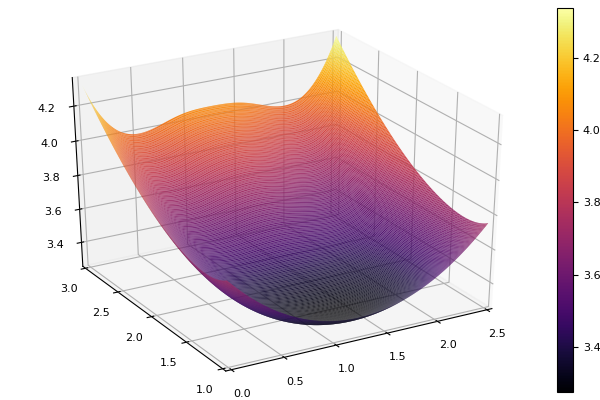

In [10]:
using Plots; pyplot()
plot(x,y,f,st=:surface,camera=(-30,30))

In [11]:
M = -Inf
m = Inf
for i in 1:length(x)
    for j in 1:length(y)
        fxy = f(x[i],y[j])
        M = max(M, fxy)
        m = min(m, fxy)
    end
end
[M,m]

2-element Array{Float64,1}:
 4.338279900321393 
 3.2751545778771693

In [7]:
x = 0:0.01:2.5
y = 1:0.01:3
f(x,y) = obj([ -0.429, 0.629, 0.245, 0.255], [x,y])

f (generic function with 1 method)

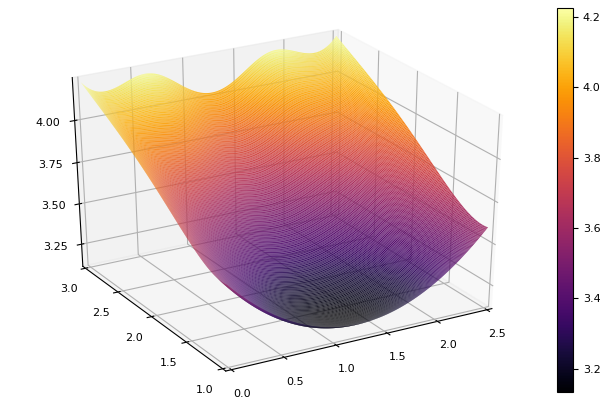

In [8]:
using Plots; pyplot()
plot(x,y,f,st=:surface,camera=(-30,30))

In [9]:
M = -Inf
m = Inf
for i in 1:length(x)
    for j in 1:length(y)
        fxy = f(x[i],y[j])
        M = max(M, fxy)
        m = min(m, fxy)
    end
end
[M,m]

2-element Array{Float64,1}:
 4.226366405440888 
 3.1330268861029618

In [23]:
output = zeros(1000)
for i in 1:1000
    output[i] = pso2([-0.446282, 1.90805, 0.249949, 0.250051],2)[1]
end

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

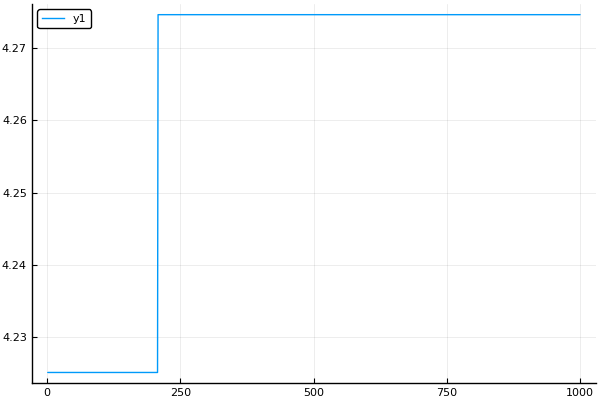

In [26]:
plot(sort(output))


In [27]:
using StatsBase
summarystats(output)

Summary Stats:
Length:         1000
Missing Count:  0
Mean:           4.264392
Minimum:        4.225075
1st Quartile:   4.274655
Median:         4.274655
3rd Quartile:   4.274655
Maximum:        4.274655


In [28]:
mean(output.< mean(output))

0.207

In [30]:
exp(4.226366405440888 - 4.274645897749711)

0.9528674307387451